In [17]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

# メーカーデータの足切り

In [18]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  
今回、最終的にはwebアプリ化を目標としているためstore_idは削除,model_number,nameはデータがないバイクが予測時に取り扱えなくなるので削除した

In [19]:
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [20]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id']).values
y = train_data['cost'].values
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

# OptunaとCVを組み合わせたパラメータチューニング

# MAPEを指標としたモデルのチューニング

In [21]:
def objective(trial):
    model = RandomForestRegressor(random_state=0)
    params = {
        'bootstrap':trial.suggest_categorical('bootstrap',[True,False]),
        'max_depth':trial.suggest_int('max_depth',1,100),
        'max_features':trial.suggest_float('max_features',0,1.0),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',1,1000),
        'n_estimators':trial.suggest_int('n_estimators',1,1000),
        'min_samples_split':trial.suggest_int('min_samples_split',2,5),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10)
    }
    reg_model=model.set_params(**params)

    #スコアをcross_val_scoreにする(cv=5,scoring=r2_score)
    score = cross_val_score(reg_model,X_learn,y_learn,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)

    mape = score.mean()

    return mape

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)

[I 2023-12-05 15:24:17,335] A new study created in memory with name: no-name-176f1fd6-f4c8-49e3-b536-eaf4d421b897
[I 2023-12-05 15:24:20,200] Trial 0 finished with value: -0.16787684762620314 and parameters: {'bootstrap': False, 'max_depth': 85, 'max_features': 0.42933065829833106, 'max_leaf_nodes': 338, 'n_estimators': 673, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: -0.16787684762620314.
[I 2023-12-05 15:24:20,823] Trial 1 finished with value: -0.874660751334347 and parameters: {'bootstrap': False, 'max_depth': 1, 'max_features': 0.19960693755230374, 'max_leaf_nodes': 652, 'n_estimators': 853, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.16787684762620314.
[I 2023-12-05 15:24:21,485] Trial 2 finished with value: -0.16487448824537349 and parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 0.6529506194772422, 'max_leaf_nodes': 182, 'n_estimators': 89, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is 

In [36]:
best_params=study.best_params
best_params

{'bootstrap': False,
 'max_depth': 28,
 'max_features': 0.5316817512634053,
 'max_leaf_nodes': 864,
 'n_estimators': 378,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

In [37]:
study.best_value

-0.14231497603595528

# チューニングしたモデルの実装

In [38]:
rf = RandomForestRegressor(random_state=0)
rf.set_params(**best_params)
rf.fit(X_learn,y_learn)

RandomForestRegressor(bootstrap=False, max_depth=28,
                      max_features=0.5316817512634053, max_leaf_nodes=864,
                      min_samples_split=4, n_estimators=378, random_state=0)

In [39]:
predict_learn = rf.predict(X_learn)
predict_val = rf.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',rf.score(X_learn,y_learn))
print('検証データr_2',rf.score(X_val,y_val))

学習データMAPE 0.061575957802362545
検証データMAPE 0.14702616312368091
学習データr_2 0.9835950298167148
検証データr_2 0.8101697607731079


In [40]:
rf.score(X_val,y_val)

0.8101697607731079

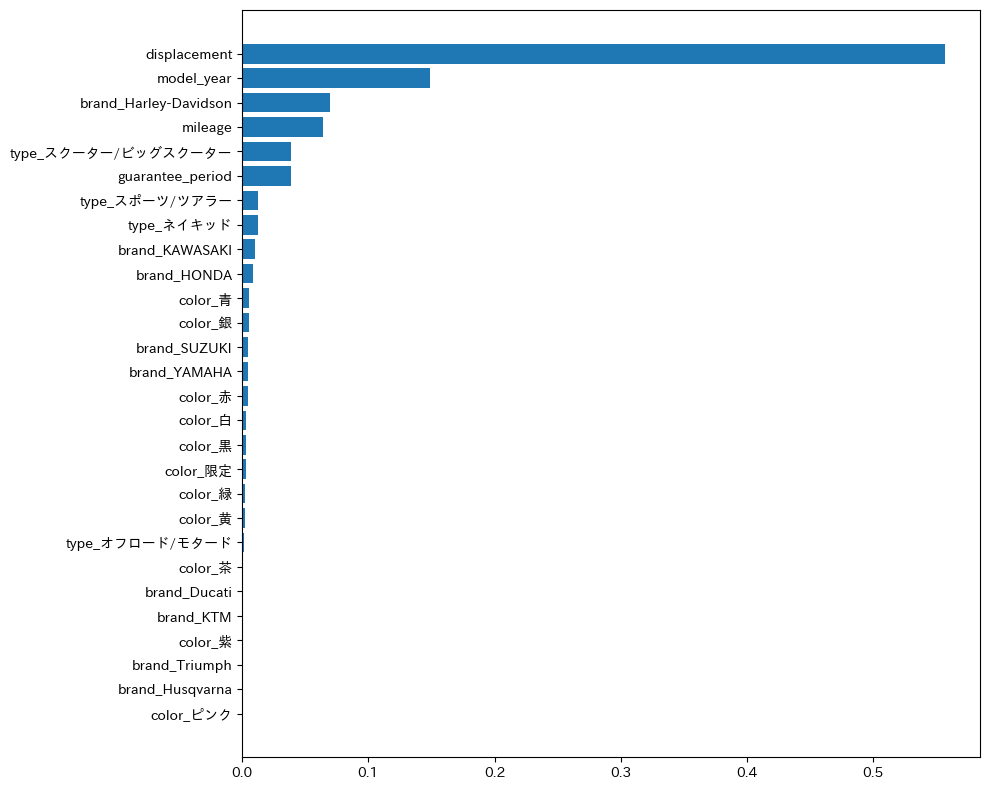

In [41]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,8))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()

# 残差プロットを作成

In [42]:
y_learn_pred = rf.predict(X_learn)
y_val_pred = rf.predict(X_val)

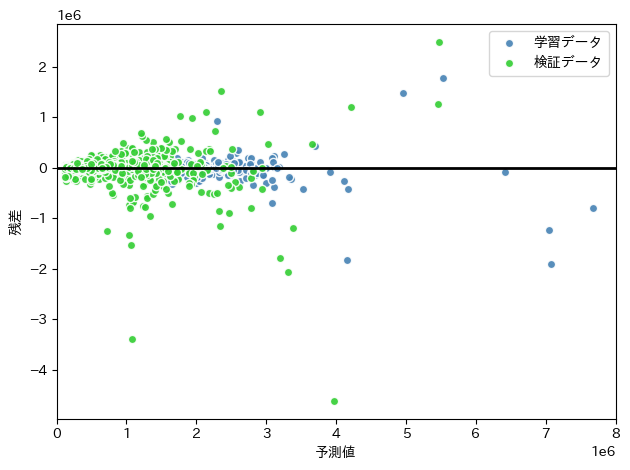

In [43]:
plt.scatter(y_learn_pred,
            y_learn_pred - y_learn,
            c='steelblue',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label = '学習データ')
plt.scatter(y_val_pred,
            y_val_pred - y_val,
            c='limegreen',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label ='検証データ')
plt.xlabel('予測値')
plt.ylabel('残差')
plt.legend()
plt.hlines(y=0,xmin=-10,xmax=8*10**6,lw=2,colors='black')
plt.xlim([-10,8*10**6])
plt.tight_layout()
plt.show()

# テストデータ検証

In [44]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)
#ダミー変数化
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
test_data=pd.get_dummies(test_data,drop_first=True,columns=encoding_target)
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id']).values
y_test = test_data['cost'].values

In [45]:
rf_test = RandomForestRegressor(random_state=0)
rf_test.set_params(**best_params)
rf_test.fit(X,y)
predict_train = rf_test.predict(X)
predict_test = rf_test.predict(X_test)
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9872199170655993
テストデータ決定係数 0.8133540302899638
訓練データMAPE 0.07061028635712713
テストデータMAPE 0.1379489765815342


## RandomForestによる予測がMAPEが最小,R^2スコアが最大となった

### flaskアプリ化を行うために、モデルをpickleファイルに保管

In [46]:
#もったいないのでtestデータも学習させたpicklefile化
X_all = np.concatenate([X,X_test])
y_all = np.concatenate([y,y_test])
rf_all = RandomForestRegressor(random_state=0)
rf_all.set_params(**best_params)
rf_all.fit(X_all,y_all)
predict_all = rf_all.predict(X_all)
print('訓練データ決定係数',r2_score(y_true=y_all,y_pred=predict_all))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y_all,y_pred=predict_all))

訓練データ決定係数 0.9879478788446135
訓練データMAPE 0.078188711541974


In [47]:
import pickle
import os 
dest = os.path.join('../flask')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(
    rf_all,open(os.path.join(dest,'regressor.pkl'),'wb'),
    protocol=4)